In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('bmh')

# Weibull

In [2]:
from scipy.stats import weibull_min

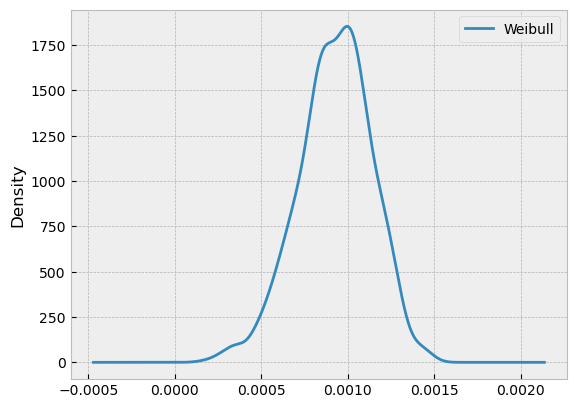

In [3]:
shape = 5
scale = .001
weibull_samples = weibull_min.rvs(shape, 0, scale, size=1000)
pd.DataFrame(weibull_samples).plot(kind='density')
plt.legend(['Weibull'])

Stanford heart transplant data:
- `time`: survival time
- `status`: censoring status

In [4]:
df = pd.read_csv('./data/stanford2.csv')
df.head()

,Unnamed: 0,id,time,status,age,t5
0,139,139,86.0,1,12,1.26
1,159,159,10.0,1,13,1.49
2,181,181,60.0,0,13,NaN
3,119,119,1116.0,0,14,0.54
4,74,74,2006.0,0,15,1.26


In [5]:
from sklearn.model_selection import train_test_split
from lifelines import WeibullFitter

In [6]:
train, test = train_test_split(df)
wbf = WeibullFitter().fit(train['time'], train['status'])

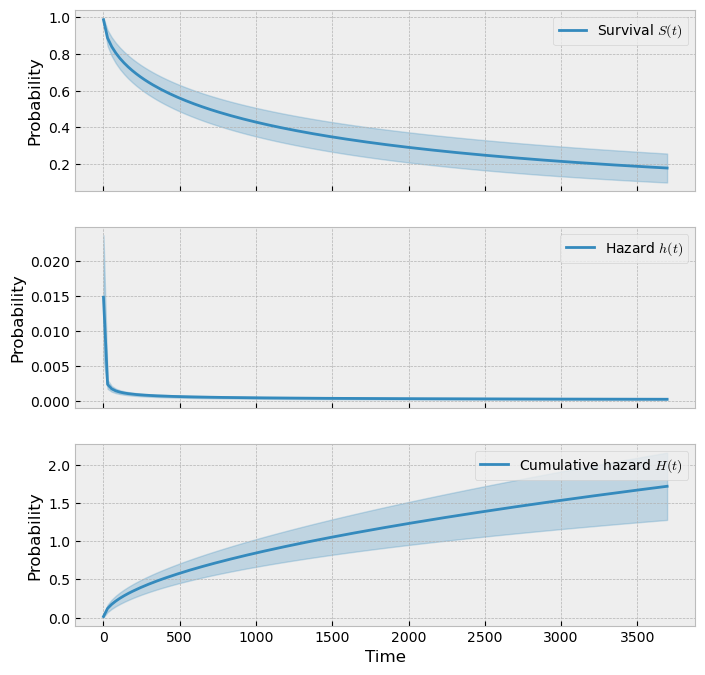

In [7]:
fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)

wbf.plot_survival_function(label=r'Survival $S(t)$', ax=axs[0]).legend();
axs[0].set_ylabel('Probability');

wbf.plot_hazard(label=r'Hazard $h(t)$', ax=axs[1]).legend();
axs[1].set_ylabel('Probability');

wbf.plot_cumulative_hazard(label=r'Cumulative hazard $H(t)$', ax=axs[2]).legend();
axs[2].set_ylabel('Probability');
axs[2].set_xlabel('Time');

- `rho_`: $\kappa$
- `lambda_`: $1/\rho$

In [8]:
wbf.lambda_, wbf.rho_

(1360.2873726853309, 0.5428245966972749)

In [9]:
def brier_score(actual, estimated):
    n = len(actual)
    error = 0
    for i in range(n):
        error += math.pow(estimated.iloc[i]-actual.iloc[i], 2)
    return error/n

In [10]:
estimated_sp = wbf.predict(test['time'])
brier_score(test['status'], 1 - estimated_sp)

0.3776871518610334

In [11]:
def compute_confidence(train, model, estimate_name):
    nu = len(train[train['status'] == 1])
    lower_col = estimate_name + '_lower'
    upper_col = estimate_name + '_upper'
    ci_limits = pd.DataFrame(columns=['time', lower_col, upper_col])
    z = 1.96
    for t_i in model.survival_function_.index:
        surv_prob = model.survival_function_.loc[t_i, estimate_name]
        ci_limit = {}
        ci_limit['time'] = t_i
        ci_limit[lower_col] = (math.exp(math.log(surv_prob) * math.exp(-z/math.sqrt(nu))))
        ci_limit[upper_col] = (math.exp(math.log(surv_prob) * math.exp(z/math.sqrt(nu))))
        ci_limits = pd.concat([ci_limits, pd.DataFrame([ci_limit])], ignore_index=True)
    return ci_limits
    
compute_confidence(train, wbf, 'Weibull_estimate').head()

/tmp/ipykernel_3061/1588422620.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ci_limits = pd.concat([ci_limits, pd.DataFrame([ci_limit])], ignore_index=True)


,time,Weibull_estimate_lower,Weibull_estimate_upper
0,0.500000,0.989027,0.983220
1,27.467153,0.907482,0.861658
2,54.434307,0.868724,0.805862
3,81.401460,0.839385,0.764498
4,108.368613,0.815049,0.730767


# Gumbel

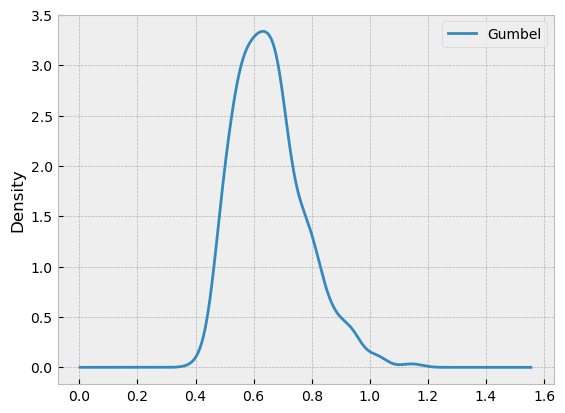

In [12]:
k, rho = 0.6, 0.1
gumbel_samples = np.random.gumbel(k, rho, 1000)

pd.DataFrame(gumbel_samples).plot(kind='density');
plt.legend(['Gumbel']);

# Exponential

In [13]:
from lifelines import ExponentialFitter

In [14]:
exf = ExponentialFitter().fit(train['time'], train['status'])

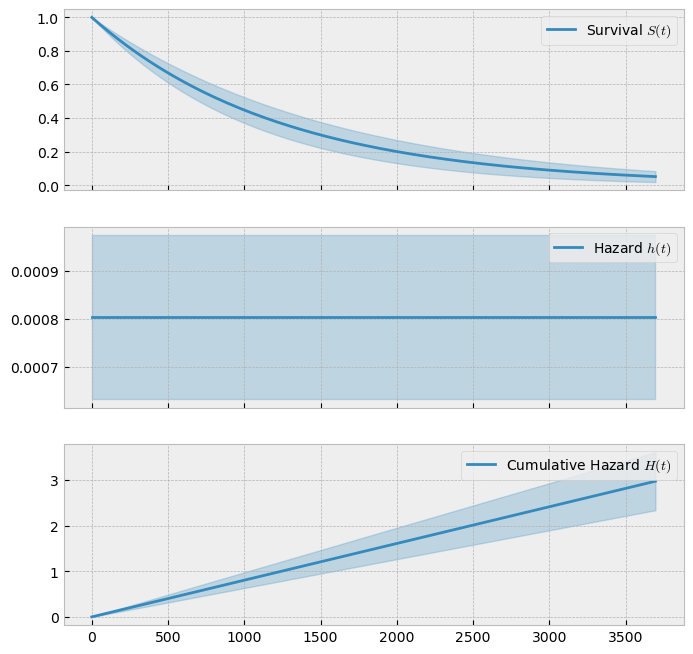

In [20]:
fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)
exf.plot_survival_function(label=r'Survival $S(t)$', ax=axs[0]).legend(); 
exf.plot_hazard(label=r'Hazard $h(t)$', ax=axs[1]).legend();
exf.plot_cumulative_hazard(label=r'Cumulative Hazard $H(t)$', ax=axs[2]).legend();

In [21]:
exf.lambda_

1244.3393567130947

# Comparison of models (AIC)

In [22]:
wbf.AIC_, exf.AIC_

(1312.4852709158388, 1367.2284756026684)